<a href="https://colab.research.google.com/github/winteryao7/DeepLearningTutorial/blob/main/Capstone_Traditional_(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification of Seismic Events Using Unsupervised Machine Learning
### Traditional Machine Learning Section
#### By Jeff Church (churchjm@umich.edu), Dongdong Yao (dongdony@umich.edu), and Yihe Huang (yiheh@umich.edu)

This notebook contains an unsupervised clustering analysis of waveforms retrieved from the [TA:O53A](http://ds.iris.edu/mda/TA/O53A/?starttime=2012-12-13T00:00:00&endtime=2018-09-27T23:59:59) seismograph station located in New Philadelphia, OH.  The analysis is performed using the K-Means clustering algorithm with manually computed features derived by seismology domain experts.

Two datasets are analyzed in this notebook, both retrieved from TA:O53A.  First, a labeled dataset containing 1,251 induced earthquakes and 5,152 mining blasts is clustered as a proof of concept.  Next, an unlabeled dataset retrieved using the [PhaseNet](https://arxiv.org/abs/1803.03211) tool (N=7,398) is analyzed using the same parameters.  All analyses are performed on the vertical seismogram channel only.

**All data files used by this notebook can be downloaded [here](https://drive.google.com/drive/folders/1-Eex84NC7S8D0qj-rliZ34Xw5-PKQuaS?usp=sharing).**

# Functions and Settings

This section contains feature generation functions, plotting functions, and various settings.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import math
from scipy.fft import rfft, rfftfreq
from scipy.integrate import simps
from scipy import signal
from scipy.stats import skew, kurtosis
from sklearn.manifold import TSNE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

import json

Data paths and random seed settings.  When running this notebook in a local environment, point ROOT_PATH to the location of the downloaded data files.

In [ ]:
ROOT_PATH = r'/content/drive/Shared drives/Capstone/Data'

LABELED_PATH = f'{ROOT_PATH}/Labeled EQ and Blasts/'
PHASENET_PATH = f'{ROOT_PATH}/PhaseNet Picks'

SAMPLE_RATE = 100.0
RANDOM_SEED = 42

eq_labeled = np.load(f'{LABELED_PATH}/wforms_eq.npy')
eq_labeled = eq_labeled[:, 2, :]
eq_timestamps = np.load(f'{LABELED_PATH}/timestamps_eq.npy')

blast_labeled = np.load(f'{LABELED_PATH}/wforms_blast.npy')
blast_labeled = blast_labeled[:, 2, :]
blast_timestamps = np.load(f'{LABELED_PATH}/timestamps_blast.npy')

phasenet = np.load(f'{PHASENET_PATH}/wforms_phasenet.npy')
phasenet = phasenet[:,2:,:].squeeze()
phasenet_wforms_downsample = np.load(f'{PHASENET_PATH}/wforms_phasenet_downsample.npy')
phasenet_timestamps = np.load(f'{PHASENET_PATH}/timestamps_phasenet.npy')

Feature generation functions.  In total, 17 features are calculated for each waveform.  These features were taken from two papers: [Johnson et al.](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2020GL088353) and [Meier et al.](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018JB016661)

The following features were selected from Johnson et al.: integral of squared trace, max spectral amplitude (top three used in this notebook), frequency of max spectral amplitude (again, top three), center frequency, and bandwidth.  See the paper's [supplementary materials](https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1029%2F2020GL088353&file=grl60885-sup-0001-2020GL088353-SI.pdf). 

From Meier et al., eight features were selected from their table 1.
1. Zero crossing rate
2. Skew
3. Kurtosis
4. Quarter comparison (Median absolute amplitude in last quarter of waveform divided by median absolute amplitude in first quarter)
5. Maximum step between consecutive samples
6. Presignal noise level (Sample standard deviation of amplitude distribution in first 4.5s of the waveform.  E.g. prior to event onset.)
7. Extreme value (Maximum absolute deviation from the mean, divided by variance)
8. Peak absolute magnitude

In [ ]:
columns = ['sq_int', 'spect_amp_1', 'spect_amp_2', 'spect_amp_3', 'freq_1', 'freq_2', 'freq_3', 'center_freq', 'bandwidth', 
           'zero_cross', 'skew', 'kurtosis', 'quarter_comp', 'max_step', 'pre_sig_noise', 'extreme_val', 'peak_abs_mag', 'label']

# Normalize each signal by its max value.  This is necessary because signals can differ by several orders of magnitude.
def normalize(arr):
  norm_arr = np.asarray([row/np.max(row) for row in arr])
  return norm_arr

def calculate_johnson_features(row):
  # Squared integral of signal
  sq_int = np.sum(row**2) # Should be equivalent to simps(row**2, dx=DELTA), because all signals have same sample rate

  coefs = abs(rfft(row)) # Calculate Fourier coefficients
  freqs = rfftfreq(len(row), 1/SAMPLE_RATE) # Get corresponding frequencies
  coefs_freqs = list(zip(freqs[1:], coefs[1:])) # Zip frequencies and coefficients.  Ignore 0Hz when getting max (signal mean)
  coefs_freqs.sort(key = lambda x: x[1], reverse=True)
  
  # Top three spectral amplitudes and corresponding frequencies
  top3 = coefs_freqs[:3]
  spect_amp_top3 = [tup[1] for tup in top3]
  freq_top3 = [tup[0] for tup in top3]

  # Center frequency
  center_freq = (coefs*freqs).sum()/coefs.sum()

  # Signal bandwidth
  bandwidth = math.sqrt(((freqs - center_freq)**2).sum()/coefs.sum())

  return [sq_int, spect_amp_top3[0], spect_amp_top3[1], spect_amp_top3[2], freq_top3[0], freq_top3[1], freq_top3[2], center_freq, bandwidth]

def calculate_meier_features(row):
  # Zero-crossing rate
  rmv_zeros = row[row!=0.0]
  crossings = (np.diff(np.sign(rmv_zeros)) != 0).sum()
  zcr = crossings/len(row)

  # Skewness
  sk = skew(row)

  # Kurtosis
  ku = kurtosis(row)

  # Quarter comparison
  q_len = int(len(row)/4)
  q1 = row[:q_len]
  q4 = row[-q_len:]
  q1_med = np.median(abs(q1))
  q4_med = np.median(abs(q4))
  qc = q4_med/q1_med

  # Maximum step
  ms = np.max(abs(np.diff(row)))

  # Pre-signal noise
  pre_signal = row[:450]
  psn = np.std(pre_signal)

  # Extreme value
  ev = np.max(abs(row)-np.mean(row))/np.var(row)

  return [zcr, sk, ku, qc, ms, psn, ev]

Dimensionality reduction and plotting functions.

In [ ]:
def get_reduced_dim_df(df, n_comp):
  X = df.copy().drop(columns=['label'], errors='ignore')
  X_standard = StandardScaler().fit_transform(X)
  pca = PCA(n_components=n_comp, svd_solver='full')
  X_pca = pca.fit_transform(X_standard)
  pca_df = pd.DataFrame(X_pca, index=df.index)

  print(f'Total explained variance: {sum(pca.explained_variance_ratio_)}') # Want >= 0.8

  return pca, pca_df

def plot_loadings(pca, feature_names):
  xs = []
  for i in range(len(feature_names)):
    xs.append(i+0.5)
  ys = []
  for i in range(len(pca.components_)):
    ys.append(i+0.5)
  ylabels = list(range(1,len(pca.components_)+1))

  fig = plt.figure(figsize=(10,3))
  sns.heatmap(pca.components_, cmap='PuOr_r', linewidths=0.05, linecolor='black', vmin=-0.3, vmax=0.3)
  plt.xticks(xs, feature_names, rotation='vertical');
  plt.yticks(ys, ylabels);
  plt.show()

def get_color(label):
  colors = ['g', 'b', 'y', 'm', 'c', 'r', 'k']
  return colors[label]

def get_class(label):
  if label == 0:
    return 'Mining Blast'
  else:
    return 'Induced Earthquake'

def get_tsne_embedding(df):
  X = df.copy().drop(columns=['label'], errors='ignore')
  X_standard = StandardScaler().fit_transform(X)
  X_embedded = TSNE(n_components=2, random_state=RANDOM_SEED).fit_transform(X_standard)
  
  return X_embedded

def soft_cluster(point, centroids):
  distribution = []
  
  distances = []
  for centroid in centroids:
    distances.append(np.linalg.norm(point - centroid))

  for i in range(len(centroids)):
    prob = round(1/np.sum((distances[i]/distances)**2),2)
    distribution.append(prob)

  return distribution

# Labeled Dataset Analysis

The labeled dataset is clustered in this section using k-means.  First, features are computed and reduced to three dimensions using PCA.  Because this is a curated dataset, we know that the number of clusters is two (induced earthquakes, and mining blasts).  The k-means clustering results are quite good, with only eight misclassifications.

The following plots are included in this section:
1. PCA loadings
2. TSNE embedding of original 17-D feature space, color coded by ground truth labels and k-means cluster assignments
3. Misclassified waveforms

In [ ]:
eq_labeled_norm = normalize(eq_labeled)
blast_labeled_norm = normalize(blast_labeled)

rows = []

for i in range(len(eq_labeled_norm)):
  j_features = calculate_johnson_features(eq_labeled_norm[i])
  m_features = calculate_meier_features(eq_labeled_norm[i])
  peak_abs_mag = np.max(abs(eq_labeled[i])) # Need original signal to get peak absolute magnitude
  
  features = j_features
  features.extend(m_features)
  features.append(peak_abs_mag)
  features.append(1) # Event label (eartquake=1)
  rows.append(features)

for i in range(len(blast_labeled_norm)):
  j_features = calculate_johnson_features(blast_labeled_norm[i])
  m_features = calculate_meier_features(blast_labeled_norm[i])
  peak_abs_mag = np.max(abs(blast_labeled[i])) # Need original signal to get peak absolute magnitude
  
  features = j_features
  features.extend(m_features)
  features.append(peak_abs_mag)
  features.append(0) # Event label (mining blast=0)
  rows.append(features)

df_labeled = pd.DataFrame(rows, columns=columns)
print(df_labeled.shape)
df_labeled.head()

(6403, 18)


,sq_int,spect_amp_1,spect_amp_2,spect_amp_3,freq_1,freq_2,freq_3,center_freq,bandwidth,zero_cross,skew,kurtosis,quarter_comp,max_step,pre_sig_noise,extreme_val,peak_abs_mag,label
0,21.459814,23.919119,23.270721,20.076880,6.664445,4.598467,6.464512,9.410034,13.345472,0.145618,0.086492,47.416113,0.684359,0.592295,0.202893,139.875788,2.999841e-07,1
1,19.225110,20.635425,19.892140,19.258379,6.664445,4.698434,6.431190,9.480498,13.644203,0.166944,0.208251,47.939479,0.504823,0.610568,0.194161,156.074833,3.016937e-07,1
2,18.575934,16.398372,16.377712,15.910568,4.731756,4.665112,6.597801,10.324337,13.192167,0.159280,-1.257495,66.564575,0.276536,0.666309,0.200071,161.555918,8.442909e-07,1
3,18.431805,21.413367,21.042230,20.238850,6.664445,4.598467,6.531156,9.464657,13.761092,0.172276,1.074869,42.431079,1.071490,0.552775,0.179851,162.831111,2.587528e-07,1
4,17.974110,17.019346,16.638833,16.235595,6.597801,6.497834,6.464512,10.298503,13.239489,0.169277,-0.865793,63.927755,0.499370,0.637386,0.193018,166.974246,4.962915e-07,1


In [ ]:
pca_labeled, pca_df_labeled = get_reduced_dim_df(df_labeled, 3) # Want >= 80%

Total explained variance: 0.8035335704323421


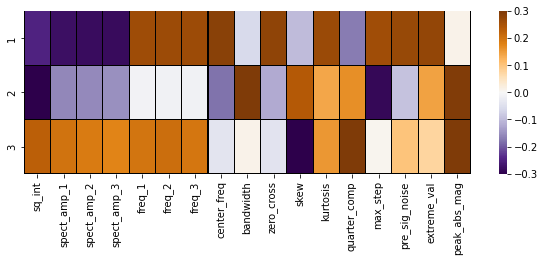

In [ ]:
plot_loadings(pca_labeled, df_labeled.columns[:-1])

In [ ]:
kmeans_labeled = KMeans(n_clusters=2, random_state=RANDOM_SEED)
y_pred_labeled = kmeans_labeled.fit_predict(pca_df_labeled)

unique, counts = np.unique(y_pred_labeled, return_counts=True)
print(dict(zip(unique, counts)))

acc_labeled = accuracy_score(df_labeled['label'], y_pred_labeled, normalize=False)
print(f'Incorrect cluster assignments: {len(df_labeled) - acc_labeled}')

{0: 5144, 1: 1259}
Incorrect cluster assignments: 8


In [ ]:
tsne_labeled = get_tsne_embedding(df_labeled)

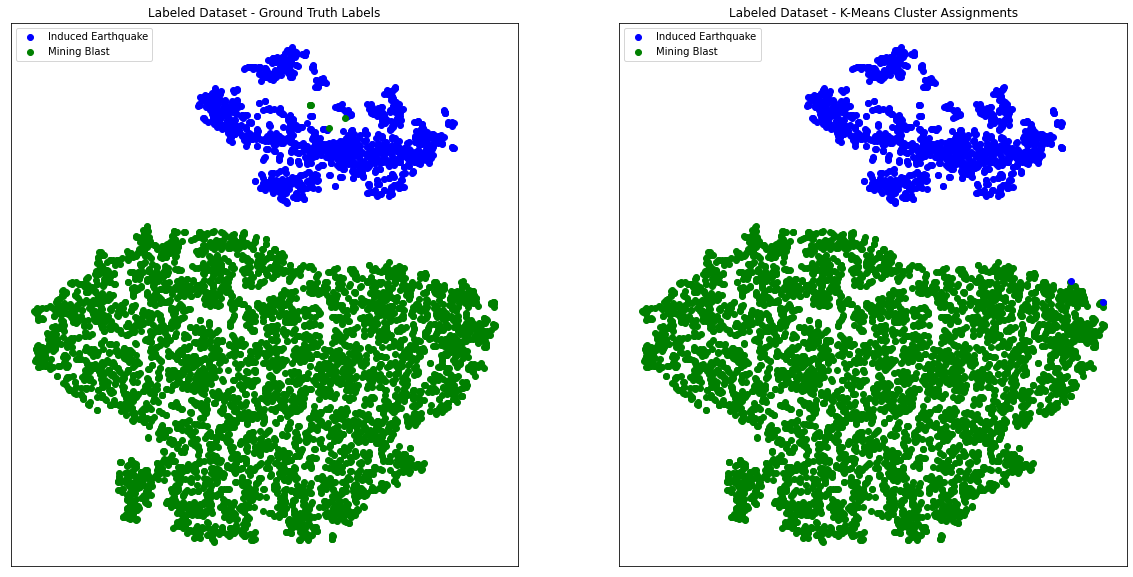

In [ ]:
labels = ['Mining Blast', 'Induced Earthquake']

fig = plt.figure(figsize=(20, 10))

ax1 = plt.subplot(121)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
plt.title('Labeled Dataset - Ground Truth Labels')

ground_truth_labeled = [tsne_labeled[np.where(df_labeled.label==0)], tsne_labeled[np.where(df_labeled.label==1)]]
for i in [1,0]:
  plt.scatter(ground_truth_labeled[i][:,0], ground_truth_labeled[i][:,1], c=get_color(i), label=labels[i])

lgnd = plt.legend(loc=2)

#lgnd.legendHandles[0]._sizes=[30]
#lgnd.legendHandles[1]._sizes=[30]

ax2 = plt.subplot(122)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
plt.title('Labeled Dataset - K-Means Cluster Assignments');

kmeans_labeled = [tsne_labeled[np.where(y_pred_labeled==0)], tsne_labeled[np.where(y_pred_labeled==1)]]
for i in [0,1]:
  plt.scatter(kmeans_labeled[i][:,0], kmeans_labeled[i][:,1], c=get_color(i), label=labels[i])

handles, labels = ax2.get_legend_handles_labels()
lgnd = plt.legend(handles[::-1], labels[::-1], loc=2)

#lgnd.legendHandles[0]._sizes=[30]
#lgnd.legendHandles[1]._sizes=[30]

plt.subplots_adjust(hspace=0.1);

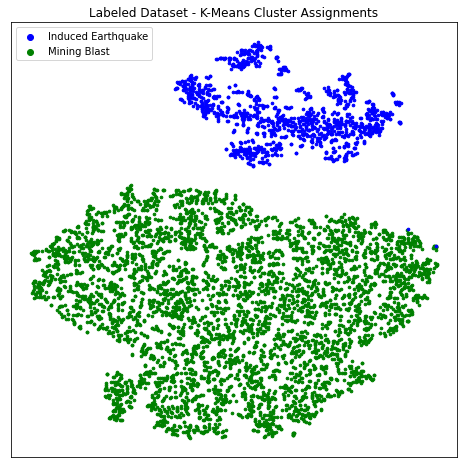

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title('Labeled Dataset - K-Means Cluster Assignments');

for i in [0,1]:
  plt.scatter(kmeans_labeled[i][:,0], kmeans_labeled[i][:,1], c=get_color(i), label=labels[i], s=7)

handles, labels = ax2.get_legend_handles_labels()
lgnd = plt.legend(handles[::-1], labels[::-1], loc=2)

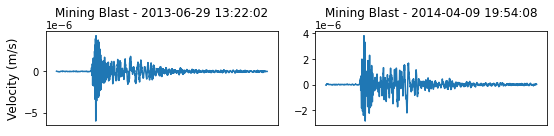

In [ ]:
# TODO: Include soft assignment probabilities?
all_labeled = np.vstack([eq_labeled, blast_labeled])
all_timestamps = np.hstack([eq_timestamps, blast_timestamps])

errors = all_labeled[df_labeled.label != y_pred_labeled]
errors_timestamps = all_timestamps[df_labeled.label != y_pred_labeled]
actuals = df_labeled[df_labeled['label'] != y_pred_labeled].reset_index().label

#plt.figure(figsize=(12, 12))
#for i in range(len(errors)):
#  ax = plt.subplot(4, 2, i+1)
#  ax.axes.xaxis.set_visible(False)
#  ax.plot(errors[i])
#  plt.title(f"{get_class(actuals[i])} - {datetime.utcfromtimestamp(errors_timestamps[i]).strftime('%Y-%m-%d %H:%M:%S')}")

fig = plt.figure(figsize=(8, 2))
for i in range(2):
  ax = plt.subplot(1, 2, i+1)
  if i==0:
    ax.set_ylabel('Velocity (m/s)', size=12)
  #fig.text(0, 0.5, 'Velocity (m/s)', va='center', rotation='vertical', size='12')
  ax.axes.xaxis.set_visible(False)
  ax.plot(errors[i])
  plt.title(f"{get_class(actuals[i])} - {datetime.utcfromtimestamp(errors_timestamps[i]).strftime('%Y-%m-%d %H:%M:%S')}", pad=15)

plt.tight_layout()

# PhaseNet Dataset Analysis

The PhaseNet dataset is clustered using the same pipeline as the labeled dataset.  However, four principal components are required here instead of three, and an elbow plot is created to confirm that the optimal number of clusters is still two.  In addition, since the PhaseNet dataset is completely unlabeled alternate evaluation methods are employed.

In [ ]:
phasenet_norm = normalize(phasenet)

rows = []

for i in range(len(phasenet_norm)):
  j_features = calculate_johnson_features(phasenet_norm[i])
  m_features = calculate_meier_features(phasenet_norm[i])
  peak_abs_mag = np.max(abs(phasenet[i])) # Need original signal to get peak absolute magnitude
  
  features = j_features
  features.extend(m_features)
  features.append(peak_abs_mag)
  rows.append(features)

df_pn = pd.DataFrame(rows, columns=columns[:-1]) # No labels
print(df_pn.shape)
df_pn.head()

(7398, 17)


,sq_int,spect_amp_1,spect_amp_2,spect_amp_3,freq_1,freq_2,freq_3,center_freq,bandwidth,zero_cross,skew,kurtosis,quarter_comp,max_step,pre_sig_noise,extreme_val,peak_abs_mag
0,10.548906,13.804689,13.715947,12.918793,6.131290,7.464179,12.262579,9.563580,16.231273,0.133622,-1.226080,132.107985,0.563063,0.787606,0.010507,320.754348,2452.515554
1,20.480718,22.063607,20.101628,19.390549,4.365212,4.398534,5.364878,6.838361,16.372178,0.103632,-0.333386,48.663518,1.045217,0.557792,0.003875,153.903183,1857.204011
2,11.212939,15.042390,14.885049,14.386824,12.229257,12.162612,12.195935,9.746112,15.776371,0.139287,-0.059842,115.797758,0.614495,0.726990,0.019468,296.250241,969.680354
3,14.280734,17.965082,17.448421,17.344998,2.799067,2.865711,4.365212,8.921819,15.611781,0.123625,0.068851,59.951703,0.673205,0.596058,0.012387,210.218227,1200.317131
4,14.042828,15.636670,15.349344,15.328421,5.998001,6.164612,6.131290,8.529820,16.056767,0.113296,-0.201627,74.710854,0.468216,0.711109,0.008856,221.989145,2417.539141


In [ ]:
pca_pn, pca_df_pn = get_reduced_dim_df(df_pn, 4) # Want >= 80%

Total explained variance: 0.8223427765766455


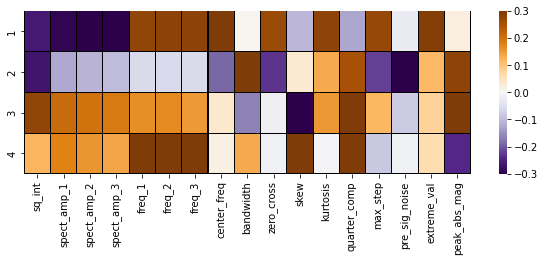

In [ ]:
plot_loadings(pca_pn, df_pn.columns)

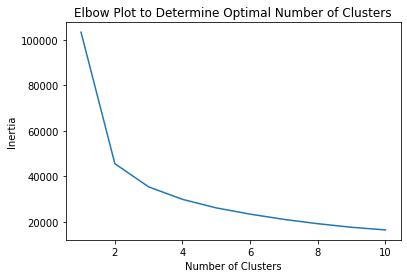

In [ ]:
lst_inertia = []
for i in range(1,11):
  kmeans = KMeans(n_clusters=i, random_state=RANDOM_SEED)
  kmeans.fit(pca_df_pn)
  lst_inertia.append(kmeans.inertia_)

plt.plot(range(1,11), lst_inertia);
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Plot to Determine Optimal Number of Clusters');

In [ ]:
kmeans_pn = KMeans(n_clusters=2, random_state=RANDOM_SEED)
y_pred_pn = kmeans_pn.fit_predict(pca_df_pn)

unique, counts = np.unique(y_pred_pn, return_counts=True)
dict(zip(unique, counts))

{0: 6006, 1: 1392}

In [ ]:
tsne_pn = get_tsne_embedding(df_pn)

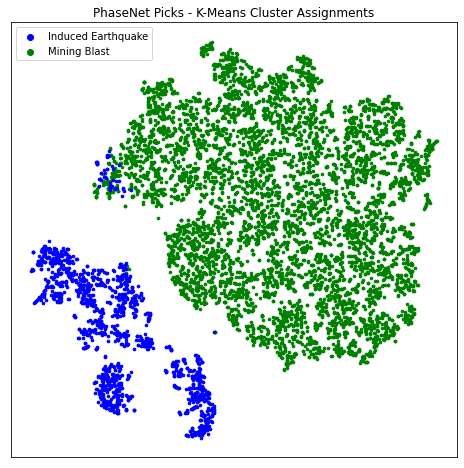

In [ ]:
labels = ['Mining Blast', 'Induced Earthquake']

fig = plt.figure(figsize=(8,8))
plt.gca().axes.xaxis.set_visible(False)
plt.gca().axes.yaxis.set_visible(False)
plt.title('PhaseNet Picks - K-Means Cluster Assignments');

kmeans_labeled = [tsne_pn[np.where(y_pred_pn==0)], tsne_pn[np.where(y_pred_pn==1)]]
for i in [0,1]:
  plt.scatter(kmeans_labeled[i][:,0], kmeans_labeled[i][:,1], c=get_color(i), label=labels[i], s=7)

handles, labels = ax2.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc=2)

plt.subplots_adjust(wspace=0.1);

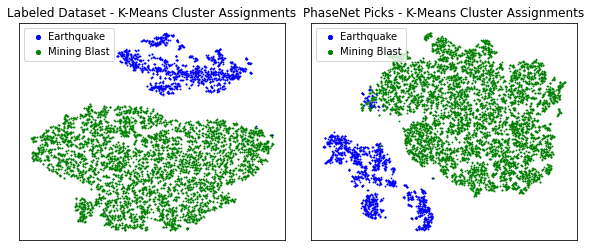

In [ ]:
labels = ['Mining Blast', 'Earthquake']

fig = plt.figure(figsize=(10,4))


ax1 = plt.subplot(1,2,1)
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
plt.title('Labeled Dataset - K-Means Cluster Assignments');

kmeans_labeled = [tsne_labeled[np.where(y_pred_labeled==0)], tsne_labeled[np.where(y_pred_labeled==1)]]
for i in [0,1]:
  plt.scatter(kmeans_labeled[i][:,0], kmeans_labeled[i][:,1], c=get_color(i), label=labels[i], s=0.7)

handles, labels = ax1.get_legend_handles_labels()
lgnd = plt.legend(handles[::-1], labels[::-1], loc=2, markerscale=5, handletextpad=0)

labels = ['Mining Blast', 'Earthquake']

ax2 = plt.subplot(1,2,2)
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
plt.title('PhaseNet Picks - K-Means Cluster Assignments');

kmeans_labeled2 = [tsne_pn[np.where(y_pred_pn==0)], tsne_pn[np.where(y_pred_pn==1)]]
for i in [0,1]:
  plt.scatter(kmeans_labeled2[i][:,0], kmeans_labeled2[i][:,1], c=get_color(i), label=labels[i], s=0.7)

handles, labels = ax2.get_legend_handles_labels()
lgnd = plt.legend(handles[::-1], labels[::-1], loc=2, markerscale=5, handletextpad=0)

plt.subplots_adjust(wspace=0.1);

In [ ]:
# Compute soft cluster assignments
#probabilities = []

#for index, row in pca_df_pn.iterrows():
#  max_prob = np.max(soft_cluster(row, kmeans_pn.cluster_centers_))
#  probabilities.append(max_prob)

In [ ]:
#json_data = []

#for i in range(len(df_pn)):
#  json_data.append({
#      'wform' : {
#          'start': phasenet_timestamps[i].item(),
#          'values': phasenet_wforms_downsample[i,2,:].tolist() 
#      },
#      'tsne_x' : tsne_pn[i,0].item(),
#      'tsne_y' : tsne_pn[i,1].item(),
#      'label' : y_pred_pn[i].item(),
#      'prob' : probabilities[i]   
#  })

#print(len(json_data))

#out_file = open(f'{PHASENET_PATH}/phasenet_tsne_traditional.json','w')
#json.dump(json_data, out_file, indent = 4)
#out_file.close()

# Evaluation of PhaseNet Clustering Results

As the PhaseNet dataset is completely unlabeled, clustering results are evaluated using the following three criteria.

1. Histogram of event onset times.  Since mining blasts are a result of human activity, we should expect the blast cluster(s) to mostly contain events with onset times during the day (e.g. working hours).  On the other hand, we should expect earthquake onset times to be more evenly spread throughout the day and night.
2. Histogram of the number of earthquakes per month.  There are four known earthquake clusters in the region during the years spanned by the PhaseNet dataset: Sep-Oct 2013, May 2014, Sep 2015, and Nov 2016.  These clusters should be easily visible in the histogram.
3. Manual inspection of clusters by domain experts using a [visualization tool](https://storage.googleapis.com/d3_phasenet_vis/trad.html).

The PhaseNet clustering results pass all three criteria.  See histogram plots for (1) and (2).  For (3), Dr. Yao confirmed that our clustering results are meaningful using the visualization tool.

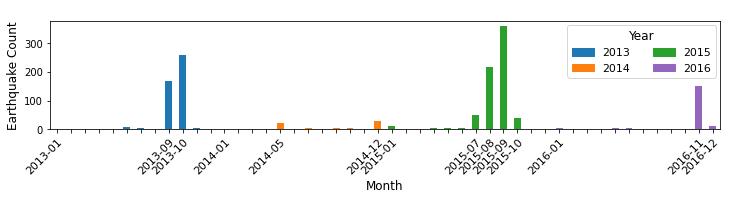

In [ ]:
import matplotlib.patches as mpatches

patch_2013 = mpatches.Patch(color='tab:blue', label='2013')
patch_2014 = mpatches.Patch(color='tab:orange', label='2014')
patch_2015 = mpatches.Patch(color='tab:green', label='2015')
patch_2016 = mpatches.Patch(color='tab:purple', label='2016')

data = {
    'cluster' : y_pred_pn,
    'timestamp' : phasenet_timestamps
}

df = pd.DataFrame(data, columns=['cluster', 'timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
group_m = df.groupby(df['timestamp'].dt.to_period('M')).sum()
group_m = group_m.resample('M').asfreq().fillna(0)
#group_m.reset_index(inplace=True)

#fig = plt.figure(figsize=(12,4))
#plt.bar(group_m['timestamp'], group_m['cluster'])

colors = ['tab:blue']*12 + ['tab:orange']*12 + ['tab:green']*12 + ['tab:purple']*12
#colors = ['b']*12 + ['g']*12 + ['y']*12 + ['m']*12


ax = group_m.plot(kind='bar', figsize=(12,2), legend=False, xlabel='Month', ylabel='Earthquake Count', color=[colors])
xticks = ax.get_xticklabels()
xticks[1:8] = ['']*7
xticks[10:12] = ['']*2
xticks[13:16] = ['']*3
xticks[17:23] = ['']*6
xticks[25:30] = ['']*5
xticks[34:36] = ['']*2
xticks[37:46] = ['']*9
ax.set_xlabel('Month', size=12)
ax.set_ylabel('Earthquake Count', size=12)
#plt.ylabel('Earthquake Count', fontsize=12)
ax.set_xticklabels(xticks, rotation=45, ha='right', rotation_mode='anchor', size=11)
fig = plt.gcf()
#loc=(0.855,0.566)
#loc=(0.075,0.44)
fig.legend(handles=[patch_2013, patch_2014, patch_2015, patch_2016], title='Year', title_fontsize=12, loc=(0.756,0.61), ncol=2, prop={'size':11});
#ax.set_xticklabels(xticks);

In [ ]:
len(group_m)

48

In [ ]:
data = {
    'cluster' : y_pred_pn,
    'timestamp' : phasenet_timestamps
}

df = pd.DataFrame(data, columns=['cluster', 'timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df['hour'] = df.apply(lambda x: x['timestamp'].hour, axis=1)
df['month'] = df.apply(lambda x: x['timestamp'].month, axis=1)
df['year'] = df.apply(lambda x: x['timestamp'].year, axis=1)

summary_stats = {}

for c in [0,1]:
  df_c = df[df['cluster']==c]
  summary_stats[f'len_{c}'] = len(df_c)
  bars_c = []
  for h in list(range(0,24)):
    df_c_hour = df_c[df_c['hour']==h]
    bars_c.append(len(df_c_hour))
  summary_stats[f'bars_{c}'] = bars_c
  print(f'Cluster length: {len(df_c)}.  Bars length: {np.sum(bars_c)}.')

Cluster length: 6006.  Bars length: 6006.
Cluster length: 1392.  Bars length: 1392.


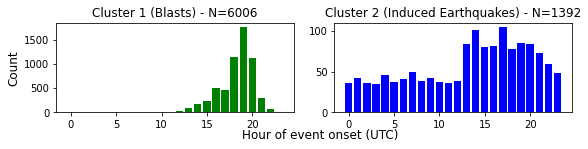

In [ ]:
fig = plt.figure(figsize=(12,2))
fig.text(0.375, 0.01, 'Hour of event onset (UTC)', ha='center', fontsize=12)

xs = list(range(0,24))

ax1 = plt.subplot(131)
ax1.bar(xs, summary_stats['bars_0'], color='g')
plt.title(f"Cluster 1 (Blasts) - N={summary_stats['len_0']}")
plt.ylabel('Count', size=12)

ax2 = plt.subplot(132)
ax2.bar(xs, summary_stats['bars_1'], color='b')
plt.title(f"Cluster 2 (Induced Earthquakes) - N={summary_stats['len_1']}");
plt.tight_layout()

In [ ]:
years = df['year'].sort_values().unique()

bars = []
num_quakes = []

df_eq = df[df['cluster']==1]
for year in years:
  df_year = df_eq[df_eq['year']==year]
  bar_y = []
  for m in range(1,13):
    df_m = df_year[df_year['month']==m]
    bar_y.append(len(df_m))
  bars.append(bar_y)
  num_quakes.append(len(df_year))
  print(len(df_year), np.sum(bar_y))

449 449
72 72
695 695
176 176


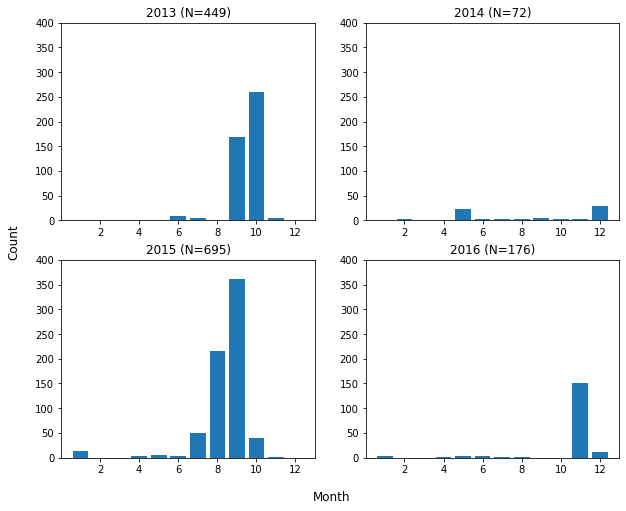

In [ ]:
fig = plt.figure(figsize=(10,8))
fig.text(0.5, 0.05, 'Month', ha='center', fontsize=12)
fig.text(0.05, 0.5, 'Count', va='center', rotation='vertical', fontsize=12)

xs = list(range(1,13))
for i in range(len(years)):
  ax = plt.subplot(2,2,i+1)
  ax.bar(xs, bars[i])
  plt.title(f'{years[i]} (N={num_quakes[i]})')
  plt.ylim((0,400))